### Projet en apprentissage statistique - Sujet n°2 :

# <center>Diagnostic de la maladie de Parkinson</center>

**Réalisé par :** Mengru CHEN, Chuyao LU, Karl MEKIE CHAMI, Dossomguimon TUO

**Rendu le :** 10/05/2022

### Table des matières

* [1. Préparation des données](#chapter1)
* [2. La classification par K-NN](#chapter2)
* [3. Méthode de la régression logistique](#chapter3)
* [4. Algorithme de la descente de gradient stochastique (version à la main)](#chapter4)
* [5. Arbre de décision](#chapter5)
* [6. Machine à Vecteurs de Support (SVM)](#chapter6)
* [7. Autre piste de proposition](#chapter7)

## 1. Préparation des données <a class="anchor" id="chapter1"></a>

Ce projet porte sur l'étude de la maladie de Parkinson basé sur 195 enregistrements vocaux des individus analysés. A partir de ces enregistrements, on retient 23 caractéristiques qui serviront à déterminer si oui ou non l'individu est atteint de la maladie.

*__Référence :__ "Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection", 
Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. 
BioMedical Engineering OnLine 2007, 6:23 (26 June 2007)*

### Importation des librairies de base

In [9]:
import pandas as pd # pour la gestion des données
import warnings # pour ignorer les éventuels messages de warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt # pour le graphique
import numpy as np # pour les types tableaux et listes
from collections import Counter # pour compter les éléments d'une liste
import time

### Importation de la base de donnée

In [2]:
parkinsons = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data',
    index_col = "name"
)

# réindexation des colonnes
parkinsons = parkinsons.reindex(columns=['status','MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'])

# nom des labels
label = parkinsons.columns[1:]

# visualisation des 6 premières expériences
parkinsons.head(6) 

,status,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
name,,,,,,,,,,,,,,,,,,,,,
phon_R01_S01_1,1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
phon_R01_S01_2,1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
phon_R01_S01_3,1,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
phon_R01_S01_4,1,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
phon_R01_S01_5,1,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
phon_R01_S01_6,1,120.552,131.162,113.787,0.00968,0.00008,0.00463,0.00750,0.01388,0.04701,...,0.03243,0.06985,0.01222,21.378,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775


### Caractéristiques de la base de donnée

Dans cette partie, nous vérifions que les informations élémentaires fournies par le site sont bien cohérentes avec note base de donnée.

In [3]:
# VERIFICATION DU NOMBRE D'INDIVIDU
# création d'une liste avec le numéro de l'individu analysé sous la forme phon_R01_Sxx
index_individu = np.array([np.array(parkinsons.index)[k][0:12] for k in range(len(parkinsons))])
print(len(Counter(index_individu)), "induvidus \n")
# remarque : on a 32 patients et non pas 31 comme le dit sur le site

# VERIFICATION VALEUR MANQUANTE
print(parkinsons.isnull().sum(), "\n")
# il n'a pas de valeurs manquantes

# VERIFICATION ABSENCE DE DOUBLONS
print(sum(parkinsons.duplicated()), "doublon")
# il n'y a aucun doublon


32 induvidus 

status              0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64 

0 doublon


### Sélection de variables

Le but est de supprimer des variables explicatives "redondantes" fournissant des informations similaires. Pour cela, nous avons observer une matrice de corrélation.

In [4]:
parkinsons.corr().style.background_gradient(cmap='coolwarm').set_precision(3)

,status,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
status,1.000,-0.384,-0.166,-0.380,0.278,0.339,0.267,0.289,0.267,0.367,0.351,0.348,0.351,0.364,0.348,0.189,-0.362,0.309,0.232,0.565,0.455,0.340,0.531
MDVP:Fo(Hz),-0.384,1.000,0.401,0.597,-0.118,-0.382,-0.076,-0.112,-0.076,-0.098,-0.074,-0.095,-0.071,-0.078,-0.095,-0.022,0.059,-0.384,-0.446,-0.414,-0.249,0.178,-0.372
MDVP:Fhi(Hz),-0.166,0.401,1.000,0.085,0.102,-0.029,0.097,0.091,0.097,0.002,0.043,-0.004,-0.010,0.005,-0.004,0.164,-0.025,-0.112,-0.343,-0.077,-0.003,0.176,-0.070
MDVP:Flo(Hz),-0.380,0.597,0.085,1.000,-0.140,-0.278,-0.101,-0.096,-0.100,-0.145,-0.119,-0.151,-0.101,-0.107,-0.151,-0.109,0.211,-0.400,-0.050,-0.395,-0.244,-0.101,-0.340
MDVP:Jitter(%),0.278,-0.118,0.102,-0.140,1.000,0.936,0.990,0.974,0.990,0.769,0.804,0.747,0.726,0.758,0.747,0.907,-0.728,0.361,0.099,0.694,0.385,0.433,0.722
MDVP:Jitter(Abs),0.339,-0.382,-0.029,-0.278,0.936,1.000,0.923,0.898,0.923,0.703,0.717,0.697,0.649,0.649,0.697,0.835,-0.657,0.442,0.175,0.736,0.389,0.311,0.748
MDVP:RAP,0.267,-0.076,0.097,-0.101,0.990,0.923,1.000,0.957,1.000,0.760,0.791,0.745,0.710,0.737,0.745,0.920,-0.722,0.342,0.064,0.648,0.324,0.427,0.671
MDVP:PPQ,0.289,-0.112,0.091,-0.096,0.974,0.898,0.957,1.000,0.957,0.798,0.839,0.764,0.787,0.804,0.764,0.845,-0.732,0.333,0.196,0.716,0.408,0.413,0.770
Jitter:DDP,0.267,-0.076,0.097,-0.100,0.990,0.923,1.000,0.957,1.000,0.760,0.791,0.745,0.710,0.737,0.745,0.920,-0.721,0.342,0.064,0.648,0.324,0.427,0.671
MDVP:Shimmer,0.367,-0.098,0.002,-0.145,0.769,0.703,0.760,0.798,0.760,1.000,0.987,0.988,0.983,0.950,0.988,0.722,-0.835,0.447,0.160,0.655,0.452,0.507,0.694


In [5]:
parkinsons_sv = parkinsons[['status','MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Shimmer', 'NHR', 'RPDE', 'DFA', 'spread1','spread2', 'D2', 'PPE']]


### Séparation des données en ensemble d'entraînement et ensemble test

Définissons ensuite les données $\mathcal{D}_n=\{(X_i, Y_i),\; 1\leq i\leq n\}$

$Y_i \in \mathcal{Y}=\{0,1\}$ est la variable d'intérêt. Ici elle représente si l'individu est atteinte de la maladie ou non.

$X_i \in \mathcal{X}=\mathbb{R}^{22}$ est la variable explicative.

In [6]:
# seul la varible "status" est de type int64, 
# les autres sont de type float64
print(parkinsons.dtypes,"\n")

X = parkinsons.select_dtypes(include="float64")
Y = parkinsons["status"]

print("La dimension de X est", X.shape) #195*22
print("La dimension de Y est", Y.shape) #195


# après selection de variables non redondantes
Xsv = parkinsons_sv.select_dtypes(include="float64")
Ysv = parkinsons_sv["status"]

print("La dimension de X après selection est", Xsv.shape) #195*12
print("La dimension de Y après selection est", Ysv.shape) #195

status                int64
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
dtype: object 

La dimension de X est (195, 22)
La dimension de Y est (195,)
La dimension de X après selection est (195, 12)
La dimension de Y après selection est (195,)


In [8]:
from sklearn.model_selection import train_test_split # pour séparer les 2 ensembles

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Xsv_train, Xsv_test, Ysv_train, Ysv_test = train_test_split(Xsv, Ysv, test_size=0.33, random_state=42)
# apres retrait de 10 variables portant des informations similaires

Xsv_test.shape

(65, 12)

## 2. Classification par K-NN <a class="anchor" id="chapter2"></a>


### Entrainement du modèle sur la base de donnée initiale

In [14]:
from sklearn.neighbors import KNeighborsClassifier

# sans selection

# Création et entraînement du modèle sur l'ensemble train
knn = KNeighborsClassifier()  # par défaut k=5

# Initialisation temps
tps = time.time()
knn.fit(X_train, Y_train)

# Prédiction sur l'ensemble test
Y_pred_knn = [knn.predict([X_test.iloc[i]])[0] for i in range(len(Y_test))]
print("Le temps nécassaire :", time.time()-tps)

# Calcul du taux de précision
accuracy = Counter(Y_pred_knn==Y_test)[True]/len(Y_test)
print("Le taux de précision :", accuracy)

# Calcul du taux de (sur-)apprentissage
Y_sapp = [knn.predict([X_train.iloc[i]])[0] for i in range(len(Y_train))]
surapp = Counter(Y_sapp==Y_train)[True]/len(Y_train)
print("Le taux d'apprentissage :", surapp)


Le temps nécassaire : 0.0972604751586914
Le taux de précision : 0.8307692307692308
Le taux d'apprentissage : 0.8846153846153846


### Entrainement du modèle sur la base de donnée après sélection de variables

In [10]:
# avec selection
tps = time.time()
knn.fit(Xsv_train, Ysv_train)

Ysv_pred = [knn.predict([Xsv_test.iloc[i]])[0] for i in range(len(Ysv_test))]
print("Le temps nécassaire :", time.time()-tps)

accuracy_sv = Counter(Ysv_pred==Ysv_test)[True]/len(Ysv_test)
print("Le taux de précision :", accuracy_sv)

Ysv_sapp = [knn.predict([Xsv_train.iloc[i]])[0] for i in range(len(Ysv_train))]
surapp_sv = Counter(Ysv_sapp==Ysv_train)[True]/len(Ysv_train)
print("Le taux d'apprentissage :", surapp_sv)


Le temps nécassaire : 0.055889129638671875
Le taux de précision : 0.8307692307692308
Le taux d'apprentissage : 0.8846153846153846


### Etude du modèle en fonction de l'évolution du nombre de voisins K-NN

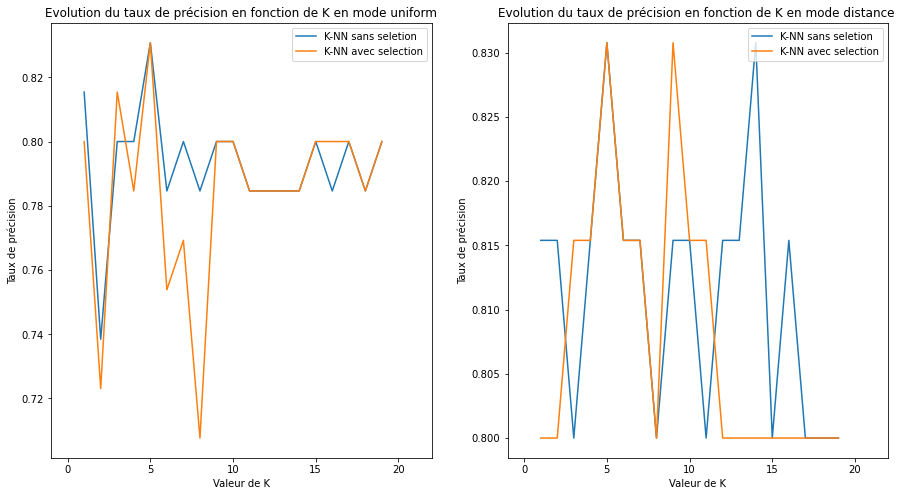

In [11]:
accuracy1 = []
accuracy_sv1 = []
accuracy2 = []
accuracy_sv2 = []

trange = range(1,20)

for k in trange :
    knn1 = KNeighborsClassifier(n_neighbors=k)
    knn2 = KNeighborsClassifier(n_neighbors=k, weights="distance")
    
    knn1.fit(X_train, Y_train)
    knn2.fit(X_train, Y_train)
    Y_pred1 = [knn1.predict([X_test.iloc[i]])[0] for i in range(len(Y_test))]
    Y_pred2 = [knn2.predict([X_test.iloc[i]])[0] for i in range(len(Y_test))]
    accuracy1.append(Counter(Y_pred1==Y_test)[True]/len(Y_test))
    accuracy2.append(Counter(Y_pred2==Y_test)[True]/len(Y_test))
    
    knn1.fit(Xsv_train, Ysv_train)
    knn2.fit(Xsv_train, Ysv_train)
    Ysv_pred1 = [knn1.predict([Xsv_test.iloc[i]])[0] for i in range(len(Ysv_test))]
    Ysv_pred2 = [knn2.predict([Xsv_test.iloc[i]])[0] for i in range(len(Ysv_test))]
    accuracy_sv1.append(Counter(Ysv_pred1==Ysv_test)[True]/len(Ysv_test))
    accuracy_sv2.append(Counter(Ysv_pred2==Ysv_test)[True]/len(Ysv_test))

fig,subplt = plt.subplots(1,2,figsize=(15,8))
subplt[0].plot(trange,accuracy1)
subplt[0].plot(trange,accuracy_sv1)
subplt[0].set_xlim([-1, 22])
subplt[0].legend(['K-NN sans seletion','K-NN avec selection'])
subplt[0].set_xlabel('Valeur de K') 
subplt[0].set_ylabel('Taux de précision')
subplt[0].set_title('Evolution du taux de précision en fonction de K en mode uniform')

subplt[1].plot(trange,accuracy2)
subplt[1].plot(trange,accuracy_sv2)
subplt[1].set_xlim([-1, 22])
subplt[1].legend(['K-NN sans seletion','K-NN avec selection'])
subplt[1].set_xlabel('Valeur de K') 
subplt[1].set_ylabel('Taux de précision')
subplt[1].set_title('Evolution du taux de précision en fonction de K en mode distance ')

plt.show()


## 3. Méthode de la régression logistique <a class="anchor" id="chapter3"></a>

### Entrainement sur les données de base

In [12]:
from sklearn.linear_model import LogisticRegression

# sans selection
Reglog = LogisticRegression(fit_intercept=True, C=1e15, penalty="none")

tps = time.time()
Reglog.fit(X_train,Y_train)

Y_pred_RegLog = [Reglog.predict([X_test.iloc[i]])[0] for i in range(len(Y_test))]
print("Le temps nécassaire :", time.time()-tps)

accuracy = Counter(Y_pred_RegLog==Y_test)[True]/len(Y_test)
print("Le taux de précision :", accuracy)

Y_sapp = [Reglog.predict([X_train.iloc[i]])[0] for i in range(len(Y_train))]
surapp = Counter(Y_sapp==Y_train)[True]/len(Y_train)
print("Le taux d'apprentissage :", surapp, "\n")

COEF_RL = Reglog.coef_
print("Les coefficients de la regression :", np.round(COEF_RL,2))
COEFb_RL = Reglog.intercept_
print("L'intercept :", np.round(COEFb_RL,2))

Le temps nécassaire : 0.04892706871032715
Le taux de précision : 0.8307692307692308
Le taux d'apprentissage : 0.8692307692307693 

Les coefficients de la regression : [[-0.01 -0.01 -0.01 -0.   -0.    0.05  0.03  0.15  0.59  6.01  0.27  0.44
   0.49  0.82 -0.05  0.13 -3.15  3.12  1.72  1.81  3.57  1.87]]
L'intercept : [1.18]


### Entrainement sur la base réduite

In [15]:
# avec selection
tps = time.time()
Reglog.fit(Xsv_train, Ysv_train)

Ysv_pred = [Reglog.predict([Xsv_test.iloc[i]])[0] for i in range(len(Ysv_test))]
print("Le temps nécassaire :", time.time()-tps)

accuracy_sv = Counter(Ysv_pred==Ysv_test)[True]/len(Ysv_test)
print("Le taux de précision :", accuracy_sv)

Ysv_sapp = [Reglog.predict([Xsv_train.iloc[i]])[0] for i in range(len(Ysv_train))]
surapp_sv = Counter(Ysv_sapp==Ysv_train)[True]/len(Ysv_train)
print("Le taux d'apprentissage :", surapp_sv, "\n")

COEF_RL_sv = Reglog.coef_
print("Les coefficients de la regression avec selection :", COEF_RL_sv)
print("L'intercept du modèle avec selction :", Reglog.intercept_)

Le temps nécassaire : 0.029935836791992188
Le taux de précision : 0.8153846153846154
Le taux d'apprentissage : 0.8769230769230769 

Les coefficients de la regression avec selection : [[-0.00606241 -0.00568845 -0.00780378 -0.01564102  0.81066281 -0.26737892
  -3.5656612   4.88009942  1.66906651  2.7468521   3.88165675  3.1634121 ]]
L'intercept du modèle avec selction : [2.73963253]


### Interprétation des features

Text(0.5, 0.98, 'Comparaison des coefficients issues de la méthode de régression logistique')

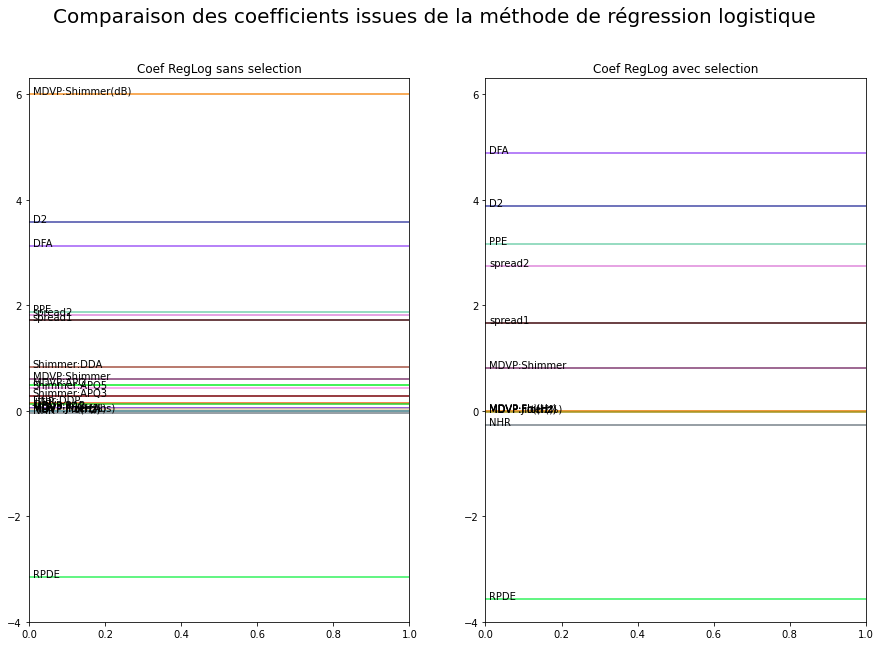

In [16]:
fig,subplt = plt.subplots(1,2,figsize=(15,10))

Taille = len(COEF_RL[0])
Col = np.random.rand(Taille,3)

# les coef de la regression logistique
for k in range(22):
    subplt[0].axhline(COEF_RL[0][k], color = Col[k])
    subplt[0].text(0.01,COEF_RL[0][k],label[k])
subplt[0].set_ylim([-4, 6.3])
subplt[0].set_title("Coef RegLog sans selection")

# les coef de la regression avec selection de variable
for k in range(12):
    if (k in range(0,4)) : 
        subplt[1].axhline(COEF_RL_sv[0][k], color = Col[k])
        subplt[1].text(0.01,COEF_RL_sv[0][k],label[k])
    elif (k==4) : 
        subplt[1].axhline(COEF_RL_sv[0][k], color = Col[k+4])
        subplt[1].text(0.01,COEF_RL_sv[0][k],label[k+4])
    elif (k==5) : 
        subplt[1].axhline(COEF_RL_sv[0][k], color = Col[k+4+5])
        subplt[1].text(0.01,COEF_RL_sv[0][k],label[k+9])
    else : 
        subplt[1].axhline(COEF_RL_sv[0][k], color = Col[k+4+5+1])
        subplt[1].text(0.01,COEF_RL_sv[0][k],label[k+10])
subplt[1].set_ylim([-4, 6.3])
subplt[1].set_title("Coef RegLog avec selection")
plt.suptitle("Comparaison des coefficients issues de la méthode de régression logistique",fontsize=20)

## 4. Algorithme de la descente de gradient stochastique (version à la main) <a class="anchor" id="chapter4"></a>

In [17]:
# transformation en type array
Xarr_train = np.array(X_train)
Xarr_test = np.array(X_test)
Yarr_train = np.array(Y_train)
Yarr_test = np.array(Y_test)


In [18]:
# la fonction sigmoide
def sigmoid(x): 
    return 1./(1.+np.exp(-x))

# la fonction de perte
def cost_log_likelihood(X, y, w, b):
    pos,neg=np.where(y==1), np.where(y==0)
    sig = sigmoid(np.dot(X[pos],w)+b)
    
    #eps = 1e-16
    #sig[sig==1]=sig[sig==1]-eps
    #sig[sig==0]=sig[sig==0]+eps
    
    pos_sum=np.sum(np.log(sig))
    neg_sum=np.sum(np.log(1-sig))
    
    return -(pos_sum+neg_sum)


In [39]:
# algo de SGD mini batch
def SGD_logistic_reg(X, y, num_steps, learning_rate, batch_size):
    
    w_init,b_init = np.array([0.]*22),0.
    #w_init,b_init = np.round(COEF_RL[0],3), COEFb_RL[0]
    #w_init,b_init = COEF_RL[0], COEFb_RL[0]
    
    w, b = w_init,b_init
    
    for step in range(num_steps):
        
        batch = np.random.choice(X.shape[0], batch_size, replace=False)
        X_batch, y_batch = X[batch], y[batch]
        
        aa = sigmoid(np.dot(X_batch,w)+b) - y_batch
        grad_w = np.matmul(X_batch.T, aa)
        grad_b = np.sum(aa)
        
        w_new = w - learning_rate * grad_w
        b_new = b - learning_rate * grad_b
        
        if step%10==0:print(cost_log_likelihood(X,y,w_new,b_new))
        
        # j'autorise a avoir un ecart de "non convergence"
        if ((cost_log_likelihood(X,y,w_init,b_init) + batch_size*2 < cost_log_likelihood(X,y,w,b)) or (cost_log_likelihood(X,y,w_new,b_new) + batch_size*2 < cost_log_likelihood(X,y,w,b))):
            print("Ne converge plus à partir de l'étape", step+1)
            return w,b
        
        w, b = w_new,b_new
        
    return w,b

print("Le cout pour la regression logistique issu du SGD est :")
w_SGD, b_SGD = SGD_logistic_reg(Xarr_train, Yarr_train, num_steps = 10000, learning_rate = 5e-7, batch_size=13)
print()
print("Le cout pour la regression logistique issu du sklearn est : \n", cost_log_likelihood(Xarr_train,Yarr_train,COEF_RL[0],COEFb_RL[0]))
print()
print("Coef issu du SGD : \n", w_SGD)
print()
print("Coef issu du sklearn : \n", COEF_RL)


Le cout pour la regression logistique issu du SGD est :
137.47028513353922
143.4116957242546
148.06121507154904
147.13471484128235
149.12827123567624
146.25955415082808
156.03129050859798
153.1260902262094
151.46971353731925
162.78991122249585
153.54726217575228
Ne converge plus à partir de l'étape 106

Le cout pour la regression logistique issu du sklearn est : 
 457.0881640969003

Coef issu du SGD : 
 [ 3.39178556e-03  2.36102258e-03  8.46511143e-04  8.69660619e-07
  6.78501692e-09  4.98789565e-07  4.92017414e-07  1.49648868e-06
  4.09531126e-06  4.02435231e-05  2.14374691e-06  2.47990326e-06
  3.42780435e-06  6.43120432e-06  4.81243158e-06  6.21102274e-04
  3.64496731e-05  4.47971916e-05 -1.23555575e-04  2.40355580e-05
  1.88301195e-04  2.69633466e-05]

Coef issu du sklearn : 
 [[-5.72503720e-03 -5.81002647e-03 -9.67397291e-03 -2.04860087e-03
  -3.95783047e-05  4.97625312e-02  3.07561752e-02  1.48964840e-01
   5.92213777e-01  6.00665566e+00  2.73898855e-01  4.38519247e-01
   4.90174

In [45]:
# prédiction avec beta et b issu de l'algo précédent sur l'ens test
Yarr_pred = [sigmoid(np.dot(Xarr_test[i],w_SGD)+b_SGD) for i in range(len(Yarr_test))]
Yarr_pred = np.array(Yarr_pred)
Yarr_pred[Yarr_pred>=0.5] = 1
Yarr_pred[Yarr_pred<0.5] = 0

# accuracy
np.sum(Yarr_pred==Yarr_test)/len(Yarr_test)

0.7384615384615385

## 5. Arbre de décision <a class="anchor" id="chapter5"></a>


### Entrainement sur la base de donnée initiale

Le temps nécassaire : 0.011425018310546875
Le taux de précision : 0.8769230769230769
Le taux d'apprentissage : 1.0


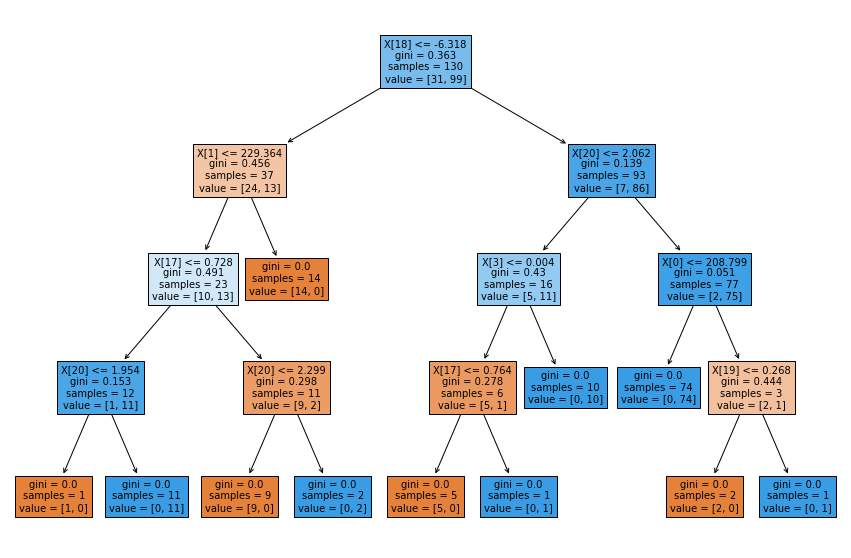

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# sans selection
arbre = DecisionTreeClassifier() # criterion="entropy" ?

tps = time.time()
arbre.fit(X_train, Y_train)

Y_pred_arbre = [arbre.predict([X_test.iloc[i]])[0] for i in range(len(Y_test))]
print("Le temps nécassaire :", time.time()-tps)

accuracy = Counter(Y_pred_arbre==Y_test)[True]/len(Y_test)
# c'est aussi ce que donne la méthode .score
print("Le taux de précision :", arbre.score(X_test, Y_test))

Y_sapp = [arbre.predict([X_train.iloc[i]])[0] for i in range(len(Y_train))]
surapp = Counter(Y_sapp==Y_train)[True]/len(Y_train)
print("Le taux d'apprentissage :", surapp)

#Affichage de l'abre de décision obtenu après entraînement
plt.figure(figsize=(15,10))
plot_tree(arbre,filled=True)
plt.show()



### Interprétabilité des features

Etant donné que la différence de temps d'exécution est minime entre le modèle issu de la base de donnée complète et celui de la base réduite, dans cette partie nous allons partir sur le modèle initial.

In [12]:
# trier les features par ordre croissant d'importance
tab_imp = pd.DataFrame({"Importance des features":arbre.feature_importances_},index=label).sort_values(
    by=["Importance des features"],ascending=False)
tab_imp

,Importance des features
spread1,0.368615
DFA,0.166576
D2,0.154212
MDVP:Fhi(Hz),0.117769
MDVP:Jitter(%),0.110310
MDVP:Fo(Hz),0.054278
spread2,0.028239
MDVP:APQ,0.000000
RPDE,0.000000
HNR,0.000000


On remarque que l'information est portée par les 7 premiers features de la liste ci-dessus. En particulier, les variables spread1 et DFA représentent déjà à plus de 50%. On se pose également de la représentation des données dans le plan porté par ces 2 variables en questions.

spread1 est la 1e variable la plus importante avec 36.86 %
DFA est la 2e variable la plus importante avec 16.66 %


Text(-2.264984000000024, 0.17428199999999996, 'Taux de précision : 84.615%')

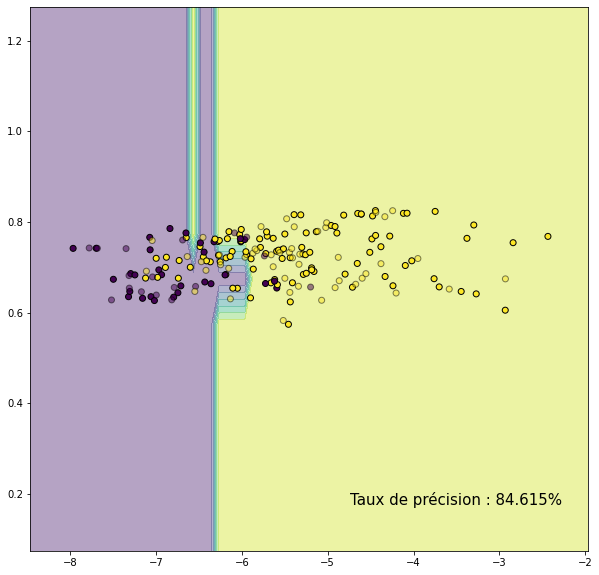

In [13]:
# selection des 2 variables les plus importantes à savoir :
print(tab_imp.iloc[0].name, "est la 1e variable la plus importante avec",round(tab_imp.iloc[0].values[0]*100,2),"%")
print(tab_imp.iloc[1].name, "est la 2e variable la plus importante avec",round(tab_imp.iloc[1].values[0]*100,2),"%")

#spread1(41%) et MDVP:Fo(Hz)(21%) 
x_min, x_max = X[tab_imp.iloc[0].name].min() - 0.5, X[tab_imp.iloc[0].name].max() + 0.5
y_min, y_max = X[tab_imp.iloc[1].name].min() - 0.5, X[tab_imp.iloc[1].name].max() + 0.5

# grille
xx,yy = np.meshgrid(np.arange(x_min,x_max,0.1), np.arange(y_min, y_max,0.1))
f, ax = plt.subplots(sharex="col", sharey="row",figsize=(10,10))

# entrainement du nouveau modèle à 2 features
arbre = DecisionTreeClassifier()
arbre.fit(X_train[[tab_imp.iloc[0].name,tab_imp.iloc[1].name]], Y_train)
Z = arbre.predict(np.c_[xx.ravel(),yy.ravel()])

# redimensionnement
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=0.4)
# plot l'ensemble d'entrainement
ax.scatter(X_train[tab_imp.iloc[0].name], X_train[tab_imp.iloc[1].name], c=Y_train, edgecolors="k")
# plot l'ensemble de test
ax.scatter(X_test[tab_imp.iloc[0].name],X_test[tab_imp.iloc[1].name],c=Y_test,edgecolors="k",alpha=0.5)

# score/accuracy/taux de précision
Y_pred = arbre.predict(X_test[[tab_imp.iloc[0].name,tab_imp.iloc[1].name]])
accuracy = Counter(Y_pred==Y_test)[True]/len(Y_test) *100
ax.text(xx.max() - 0.3, yy.min() + 0.1,(f"Taux de précision : {round(accuracy,3)}%"  ),size=15,horizontalalignment="right")

### Entrainement sur la base de donnée avec sélection de variable

Le temps nécassaire : 0.012502908706665039
Le taux de précision : 0.8769230769230769
Le taux d'apprentissage : 1.0


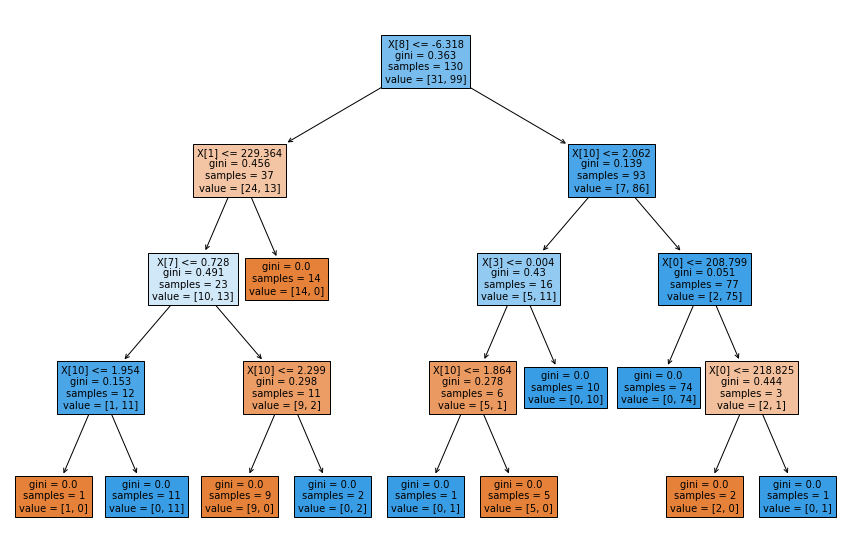

In [54]:
# avec selection
tps = time.time()
arbre.fit(Xsv_train, Ysv_train)

Ysv_pred = [arbre.predict([Xsv_test.iloc[i]])[0] for i in range(len(Ysv_test))]
print("Le temps nécassaire :", time.time()-tps)

print("Le taux de précision :", arbre.score(Xsv_test, Ysv_test))

Ysv_sapp = [arbre.predict([Xsv_train.iloc[i]])[0] for i in range(len(Ysv_train))]
surapp_sv = Counter(Ysv_sapp==Ysv_train)[True]/len(Ysv_train)
print("Le taux d'apprentissage :", surapp_sv)

#Affichage de l'abre de décision obtenu après entraînement
plt.figure(figsize=(15,10))
plot_tree(arbre,filled=True)
plt.show()


## 6. Machine à Vecteurs de Support (SVM) <a class="anchor" id="chapter6"></a>


### Entrainement sur la base de donnée initiale

In [55]:
from sklearn.svm import SVC

# considérons la base de données complète

# créattion des modèles
SVM_lin = SVC(kernel='linear') #SVM avec noyau linéaire
SVM_poly = SVC(kernel="poly") #SVM avec noyau polynomial
SVM_sigm = SVC(kernel='sigmoid') #SVM avec noyau sigmoide
SVM_rad = SVC() #SVM avec noyeau à base radiale

# entrainemment des modèles
SVM_lin.fit(X_train, Y_train)
SVM_poly.fit(X_train, Y_train)
SVM_sigm.fit(X_train, Y_train)
SVM_rad.fit(X_train, Y_train)

# cas du modèle avec noyeau linéaire
Y_sapp_lin = SVM_lin.predict(X_train)
Y_pred_lin = SVM_lin.predict(X_test)
print( "Le taux de précision sur le modèle à noyau linéaire est : \n", SVM_lin.score(X_train, Y_train),"sur la base d'entrainement et \n",SVM_lin.score(X_test, Y_test),"sur la base de test" )
print()

# cas du modèle avec noyeau polynomial
Y_sapp_poly = SVM_poly.predict(X_train)
Y_pred_poly = SVM_poly.predict(X_test)
print( "Le taux de précision sur le modèle à noyau polynomial est : \n",SVM_poly.score(X_train, Y_train) ,"sur la base d'entrainement et \n",SVM_poly.score(X_test, Y_test),"sur la base de test" )
print()

# cas du modèle avec noyeau sigmoidal
Y_sapp_sigm = SVM_sigm.predict(X_train)
Y_pred_sigm = SVM_sigm.predict(X_test)
print( "Le taux de précision sur le modèle à noyau sigmoidal est : \n",SVM_sigm.score(X_train, Y_train) ,"sur la base d'entrainement et \n", SVM_sigm.score(X_test, Y_test) ,"sur la base de test" )
print()

# cas du modèle avec noyeau à base radiale
Y_sapp_rad = SVM_rad.predict(X_train)
Y_pred_rad = SVM_rad.predict(X_test)
print( "Le taux de précision sur le modèle à noyau radial est : \n",SVM_rad.score(X_train, Y_train) ,"sur la base d'entrainement et \n",SVM_rad.score(X_test, Y_test) ,"sur la base de test" )


Le taux de précision sur le modèle à noyau linéaire est : 
 0.8769230769230769 sur la base d'entrainement et 
 0.8461538461538461 sur la base de test

Le taux de précision sur le modèle à noyau polynomial est : 
 0.8615384615384616 sur la base d'entrainement et 
 0.7846153846153846 sur la base de test

Le taux de précision sur le modèle à noyau sigmoidal est : 
 0.7615384615384615 sur la base d'entrainement et 
 0.7384615384615385 sur la base de test

Le taux de précision sur le modèle à noyau radial est : 
 0.8307692307692308 sur la base d'entrainement et 
 0.7846153846153846 sur la base de test


### Entrainement sur la base de donnée avec sélection de variable

In [56]:
# considérons la base de données obtenue apres avoir fait une réduction de variables grace a une étude de corrélation

# entrainemment des modèles
SVM_lin.fit(Xsv_train, Ysv_train)
SVM_poly.fit(Xsv_train, Ysv_train)
SVM_sigm.fit(Xsv_train, Ysv_train)
SVM_rad.fit(Xsv_train, Ysv_train)

# cas du modèle avec noyeau linéaire
Ysv_sapp_lin = SVM_lin.predict(Xsv_train)
Ysv_pred_lin = SVM_lin.predict(Xsv_test)
print( "Le taux de précision sur le modèle à noyau linéaire est : \n", SVM_lin.score(Xsv_train, Ysv_train),"sur la base d'entrainement et \n",SVM_lin.score(Xsv_test, Ysv_test),"sur la base de test" )
print()

# cas du modèle avec noyeau polynomial 
Ysv_sapp_poly = SVM_poly.predict(Xsv_train)
Ysv_pred_poly = SVM_poly.predict(Xsv_test)
print( "Le taux de précision sur le modèle à noyau linéaire est : \n", SVM_poly.score(Xsv_train, Ysv_train),"sur la base d'entrainement et \n",SVM_poly.score(Xsv_test, Ysv_test),"sur la base de test" )
print()

# cas du modèle avec noyeau sigmoide
Ysv_sapp_sigm = SVM_sigm.predict(Xsv_train)
Ysv_pred_sigm = SVM_sigm.predict(Xsv_test)
print( "Le taux de précision sur le modèle à noyau linéaire est : \n", SVM_sigm.score(Xsv_train, Ysv_train),"sur la base d'entrainement et \n",SVM_sigm.score(Xsv_test, Ysv_test),"sur la base de test" )
print()

# cas du modèle avec noyeau à base radiale
Ysv_sapp_rad = SVM_rad.predict(Xsv_train)
Ysv_pred_rad = SVM_rad.predict(Xsv_test)
print( "Le taux de précision sur le modèle à noyau linéaire est : \n", SVM_rad.score(Xsv_train, Ysv_train),"sur la base d'entrainement et \n",SVM_rad.score(Xsv_test, Ysv_test),"sur la base de test" )


Le taux de précision sur le modèle à noyau linéaire est : 
 0.8769230769230769 sur la base d'entrainement et 
 0.8461538461538461 sur la base de test

Le taux de précision sur le modèle à noyau linéaire est : 
 0.8384615384615385 sur la base d'entrainement et 
 0.7692307692307693 sur la base de test

Le taux de précision sur le modèle à noyau linéaire est : 
 0.7615384615384615 sur la base d'entrainement et 
 0.7384615384615385 sur la base de test

Le taux de précision sur le modèle à noyau linéaire est : 
 0.8307692307692308 sur la base d'entrainement et 
 0.7846153846153846 sur la base de test


## 7. Autre piste de proposition <a class="anchor" id="chapter7"></a>


In [57]:
#np.array(Y_pred_knn)
#np.array(Y_pred_RegLog)
#np.array(Y_pred_arbre)
#np.array(Y_pred_lin)

# création de dataframe contenant tous les predictions des différents modèles
ensemble_Ypred = pd.DataFrame({'Knn': Y_pred_knn,'RegLog': Y_pred_RegLog,'Arbre': Y_pred_arbre,
                                    'SVM linéaire': Y_pred_lin, 'SVM polynomiale': Y_pred_poly,
                                    'SVM sigmoidale': Y_pred_sigm, 'SVM radiale': Y_pred_rad})

# je prédis 1 si la majorité des modèles donnnent 1 en prédiction (la valeur du milieu est de 4)
ensemble_Ypred["#{Y_pred = 1}"] = ensemble_Ypred.sum(axis=1)
ensemble_Ypred['Y_pred_new'] = [1 if x>=4 else 0 for x in ensemble_Ypred['#{Y_pred = 1}']]

# pour les modèles sans KNN
Y_pred_new = list(ensemble_Ypred["Y_pred_new"])
accuracy = np.sum(Y_pred_new==Y_test)/len(Y_test)
print("Le taux de précision est: ",accuracy)
ensemble_Ypred

Le taux de précision est:  0.8615384615384616


,Knn,RegLog,Arbre,SVM linéaire,SVM polynomiale,SVM sigmoidale,SVM radiale,#{Y_pred = 1},Y_pred_new
0,1,1,1,1,1,1,1,7,1
1,1,1,1,1,1,1,1,7,1
2,1,1,1,1,1,1,1,7,1
3,1,1,1,1,1,1,1,7,1
4,1,1,1,1,1,1,1,7,1
...,...,...,...,...,...,...,...,...,...
60,0,0,0,0,1,1,1,3,0
61,1,1,1,1,1,1,1,7,1
62,1,0,1,1,1,1,1,6,1
63,1,1,1,1,1,1,1,7,1
